# **Wikipedia Simplifier : Assignment 4**
---
> **By Team 4** :
*   Pratham Jain
*   Rashmi G R
*   Rishav Bikarwar

---
> **Mentors** :
*   Ananya Gupta
*   Rishabh Dugaye

---

## **Movie Review Sentiment Analysis**

**Importing Useful Libraries**

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

**Loading IMDB movie review dataset**

In [2]:
dataset = tfds.load('imdb_reviews', as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [3]:
print(len(train_dataset), len(test_dataset))

25000 25000


In [4]:
BUFFER_SIZE = 15000
BATCH_SIZE = 64

In [5]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I'm sorry, but this may have been scary in 1978 when it came out, but in modern times it just doesn't hold up. The only interesting scene in the entire movie is the opening scene where Michael kills his sister, Judith, wearing his Halloween mask. The most startling moment in the whole film is when his parents rip the mask off to see their son killed their daughter. The film goes downhill from there and doesn't pick up until the last fifteen minutes, but by then it's too late, we the audience have lost all interest in the story. There is barely any character development, and people always rave about Laurie being such an exceptional heroine, when there really isn't much to her. I'm sorry to disagree with everyone terrified by this movie, but if you want a great horror movie go watch The Shining or Rosemary's Baby. Those are the two best horror films ever made. Halloween is certainly not in their ranks. I can't believe Roger Ebert gave it four stars, for there is no way this fi

**Creating the Text Encoder**

In [7]:
VOCAB_SIZE = 2000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
word_index = {word:idx for word, idx in zip(vocab, range(len(vocab)))}
vocab[:10]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it'],
      dtype='<U14')

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 142,  786,   19, ...,    0,    0,    0],
       [1841,    1,    3, ...,    0,    0,    0],
       [  51,   11,   14, ...,    0,    0,    0]])

##**Model-1**

**Creating Model**

In [14]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [15]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Training the Model**

In [17]:
history = model.fit(train_dataset, epochs=8,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/8
391/391 [==============================] - 40s 83ms/step - loss: 0.6792 - accuracy: 0.5227 - val_loss: 0.5561 - val_accuracy: 0.7786
Epoch 2/8
391/391 [==============================] - 31s 77ms/step - loss: 0.4487 - accuracy: 0.7808 - val_loss: 0.3704 - val_accuracy: 0.8469
Epoch 3/8
391/391 [==============================] - 31s 78ms/step - loss: 0.3359 - accuracy: 0.8605 - val_loss: 0.3301 - val_accuracy: 0.8604
Epoch 4/8
391/391 [==============================] - 31s 77ms/step - loss: 0.2985 - accuracy: 0.8773 - val_loss: 0.3146 - val_accuracy: 0.8708
Epoch 5/8
391/391 [==============================] - 31s 77ms/step - loss: 0.2773 - accuracy: 0.8867 - val_loss: 0.3079 - val_accuracy: 0.8714
Epoch 6/8
391/391 [==============================] - 31s 77ms/step - loss: 0.2657 - accuracy: 0.8906 - val_loss: 0.3029 - val_accuracy: 0.8724
Epoch 7/8
391/391 [==============================] - 31s 77ms/step - loss: 0.2578 - accuracy: 0.8961 - val_loss: 0.3040 - val_accuracy: 0.8766

**Evaluating the Model**

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 15s 38ms/step - loss: 0.3219 - accuracy: 0.8742
Test Loss: 0.32185643911361694
Test Accuracy: 0.8741599917411804


**Sample Text Prediction**

In [19]:
sample_text = ('The movie was insanely good. How can someone produce such a mind boggling movie? Totally love it.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.7270078]]


---

## **Model-2 (Using Pretrained Word-Embeddings)**

**Importing GloVe Pre-Trained Word Embeddings**

In [20]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-05-23 15:33:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-23 15:33:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-23 15:33:11--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [21]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [22]:
path_to_glove_file = '/content/glove.6B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [23]:
NUM_TOKENS = len(vocab) + 2
EMBEDDING_DIM = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((NUM_TOKENS, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 1986 words (14 misses)


**Embedding Layer**

In [24]:
embedding_layer = tf.keras.layers.Embedding(
    NUM_TOKENS,
    EMBEDDING_DIM,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    mask_zero=True,
    trainable=False,
)

**Creating Model**

In [25]:
model = tf.keras.Sequential([
    encoder,
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Training the Model**

In [28]:
history = model.fit(train_dataset, epochs=8,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/8
391/391 [==============================] - 37s 79ms/step - loss: 0.6162 - accuracy: 0.6240 - val_loss: 0.4816 - val_accuracy: 0.7365
Epoch 2/8
391/391 [==============================] - 29s 74ms/step - loss: 0.4427 - accuracy: 0.7872 - val_loss: 0.3920 - val_accuracy: 0.8156
Epoch 3/8
391/391 [==============================] - 30s 75ms/step - loss: 0.3912 - accuracy: 0.8193 - val_loss: 0.3745 - val_accuracy: 0.8318
Epoch 4/8
391/391 [==============================] - 30s 76ms/step - loss: 0.3431 - accuracy: 0.8455 - val_loss: 0.3418 - val_accuracy: 0.8448
Epoch 5/8
391/391 [==============================] - 30s 75ms/step - loss: 0.3187 - accuracy: 0.8559 - val_loss: 0.3393 - val_accuracy: 0.8568
Epoch 6/8
391/391 [==============================] - 30s 75ms/step - loss: 0.3011 - accuracy: 0.8665 - val_loss: 0.3363 - val_accuracy: 0.8714
Epoch 7/8
391/391 [==============================] - 30s 74ms/step - loss: 0.2766 - accuracy: 0.8809 - val_loss: 0.3457 - val_accuracy: 0.8693

In [29]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.5706837952136994)

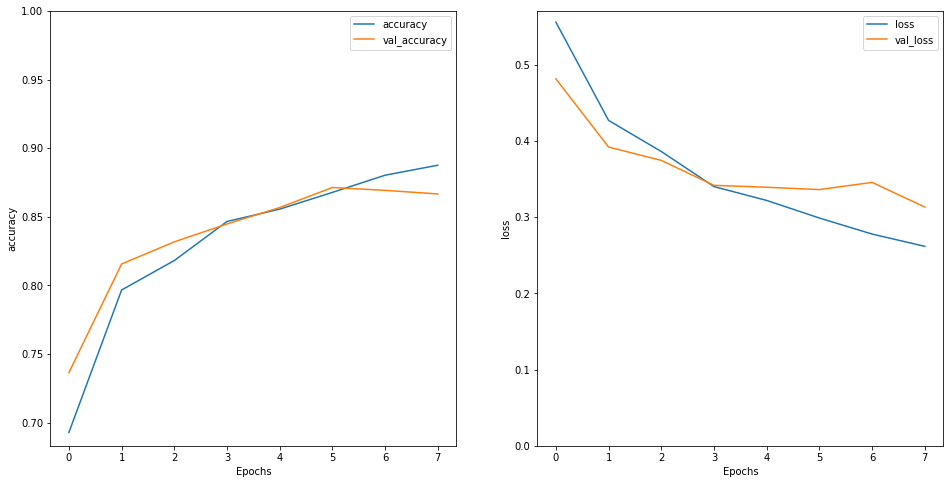

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

**Evaluating the Model**

In [31]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 16s 41ms/step - loss: 0.3124 - accuracy: 0.8615
Test Loss: 0.31243282556533813
Test Accuracy: 0.8614799976348877


**Sample Text Prediction**

In [39]:
sample_text_1 = ('This movie was a complete disaster. Acting from the lead actor was not that bad. ' 
                    'But the storyline was poor. Why did then even thought of making such a ridiculous movie?')
predictions = model.predict(np.array([sample_text_1]))
print(predictions)

[[-4.700093]]
